In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import argparse, os
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout
from keras import backend as K
from keras import optimizers
from keras.layers import Input, Dense, Flatten, Lambda, Concatenate, Reshape, \
    TimeDistributed, LSTM, RepeatVector, SimpleRNN, Activation
from keras.models import Model, load_model
from keras.callbacks import TensorBoard
from keras.losses import mse
from keras.utils import plot_model
from numpy import shape

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
        #   'figure.figsize': (19.2, 10.8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

if __name__ == '__main__':
    project_path = '/content/drive/MyDrive/master project/git/mmfall/'
print("INFO: Load train/test data...")
train_data      = np.load(project_path + 'data/normal_train_data.npy', allow_pickle=True)
test_data       = np.load(project_path + 'data/normal_test_data.npy', allow_pickle=True)
shape(train_data)

INFO: Load train/test data...


(60816, 10, 64, 4)

In [ ]:

class data_preproc:
    def __init__(self):
        # One motion pattern is as (self.frames_per_pattern, self.points_per_frame, self.features_per_point)
        self.frames_per_pattern     = 10 # For 1 second for 10 fps radar rate
        self.points_per_frame       = 64 # We want to oversample every radar frame to 64 points while keeping the mean and variance the same
        self.features_per_point     = 4  # The radar can provides us (x, y, z, Doppler, RCS), but we only keep the first four feature, i.e. (x, y, z, Doppler)

        # Train and test data split ratio
        self.split_ratio            = 0.8

        # Rotation matrix due to tilt angle
        tilt_angle  = 10.0 # degrees
        self.height = 1.8   # meters
        self.rotation_matrix = np.array([[1.0, 0.0, 0.0],\
                                        [0.0, np.cos(np.deg2rad(tilt_angle)), np.sin(np.deg2rad(tilt_angle))],\
                                        [0.0, -np.sin(np.deg2rad(tilt_angle)), np.cos(np.deg2rad(tilt_angle))]])

    def load_bin(self, binfile_path, fortrain=True):
        # Record centroid history for analysis purpose
        centroidX_his = []
        centroidY_his = []
        centroidZ_his = []

        # Load the recorded bin file
        raw_pointcloud = np.load(binfile_path, allow_pickle=True)

        # Accumulated the motion patterns with (self.frames_per_pattern) frames
        total_pattern = []
        for idx in range(len(raw_pointcloud)-self.frames_per_pattern):
            total_pattern.append(raw_pointcloud[idx : (idx + self.frames_per_pattern)])

        # Original point vector in the .bin file:
        #   [frame number, point ID, target ID, \\ Basic information
        #   centroidX, centroidY, centroidZ, centroidVelocityX, centroidVelocityY, centroidVelocityZ, \\ Centorid information
        #   range, azimuth angle, elevation angle, Doppler, SNR, noise level] \\ Point information
        # Extract the feature vector (delta_x, delta_y, z, D, pointRCS) from the original point vector and do data oversampling proposed in the paper
        total_processed_pattern = []
        total_processed_no_norm = []
        for pattern in total_pattern:
            # Get the centroid information from the very first frame in a pattern and do coordiante transformation
            # As the centroid is already in the radar Cartesian coordinates, we just need to transfer it to the ground Cartesian coordinates
            centroidX, centroidY, centroidZ, centroidVx, centroidVy, centroidVz = pattern[0][0][3], pattern[0][0][4], pattern[0][0][5], pattern[0][0][6], pattern[0][0][7], pattern[0][0][8]
            results      = np.matmul(self.rotation_matrix, np.array([centroidX,centroidY,centroidZ]))
            centroidX    = results[0]
            centroidY    = results[1]
            centroidZ    = results[2] + self.height

            # Record the centroid history over time
            centroidX_his.append(centroidX)
            centroidY_his.append(centroidY)
            centroidZ_his.append(centroidZ)

            processed_pattern  = []
            for frame in pattern:
                processed_frame = []
                for point in frame:
                    # Get the original point information.
                    pointR, pointAZ, pointEL, pointD, pointSNR, pointNoise = point[9], point[10], point[11], point[12], point[13], point[14]

                    # Get the point's position in the Cartesian coord and then do coordiante transformation
                    pointX      = pointR*np.cos(pointEL)*np.sin(pointAZ)
                    pointY      = pointR*np.cos(pointEL)*np.cos(pointAZ)
                    pointZ      = pointR*np.sin(pointEL)
                    results     = np.matmul(self.rotation_matrix, np.array([pointX, pointY, pointZ]))
                    pointX      = results[0]
                    pointY      = results[1]
                    pointZ      = results[2] + self.height

                    # Subtract the point's position from the centroid in the very first frame in a motion pattern
                    delta_x     = pointX - centroidX
                    delta_y     = pointY - centroidY
                    delta_z     = pointZ
                    delta_D     = pointD
                    pointRCS    = 4*10*np.log10(pointR) + pointSNR*0.1 + pointNoise*0.1 # in dBsm

                    # Form the feature vector for each frame
                    feature_vector = [delta_x, delta_y, delta_z, delta_D, pointRCS]
                    processed_frame.append(feature_vector[0:self.features_per_point]) # Only keep 3D spatial info and the Doppler
                processed_pattern.append(processed_frame)
                # Do the data oversampling proposed in the paper
                processed_pattern_oversampled = self.proposed_oversampling(processed_pattern)
            total_processed_pattern.append(processed_pattern_oversampled)

        total_processed_pattern_np = np.array(total_processed_pattern)

        # Train and test split
        split_idx   = int(total_processed_pattern_np.shape[0]*self.split_ratio)
        traindata   = total_processed_pattern_np[0:split_idx]
        testdata    = total_processed_pattern_np[split_idx:]

        if fortrain is True: # For training, need data split to obtain both training and testing dataset
            print("INFO: Total normal motion pattern data shape: " + str(total_processed_pattern_np.shape))
            print("INFO: Training motion pattern data shape" + str(traindata.shape))
            print("INFO: Testing motion pattern data shape" + str(testdata.shape))
            return traindata, testdata
        else: # For inference on anomaly dataset
            print("INFO: Total inference motion pattern data shape: " + str(total_processed_pattern_np.shape))
            return total_processed_pattern, centroidZ_his

    def proposed_oversampling(self, processed_pointcloud):
        # # Check the input
        # point_list = []
        # for frame in processed_pointcloud:
        #     point_list.extend(frame)
        # point_list_np  = np.array(point_list)
        # assert (point_list_np.shape[-1] == self.features_per_point), ("ERROR: Input processed_pointcloud has different feature length rather than %s!" %(self.features_per_point))

        # Do the data oversampling
        processed_pointcloud_oversampled = []
        for frame in processed_pointcloud:
            frame_np = np.array(frame)
            # Check if it's empty frame
            N = self.points_per_frame
            M = frame_np.shape[0]
            assert (M != 0), "ERROR: empty frame detected!"
            # Rescale and padding
            mean        = np.mean(frame_np, axis=0)
            sigma       = np.std(frame_np, axis=0)
            frame_np    = np.sqrt(N/M)*frame_np + mean - np.sqrt(N/M)*mean # Rescale
            frame_oversampled = frame_np.tolist()
            frame_oversampled.extend([mean]*(N-M)) # Padding with mean
            # # Check if mean and sigma keeps the same. Comment for saving time.
            # new_mean    = np.mean(np.array(frame_oversampled), axis=0)
            # new_sigma   = np.std(np.array(frame_oversampled), axis=0)
            # assert np.sum(np.abs(new_mean-mean))<1e-5, ("ERROR: Mean rescale and padding error!")
            # assert np.sum(np.abs(new_sigma-sigma))<1e-5, ("ERROR: Sigma rescale and padding error!")
            processed_pointcloud_oversampled.append(frame_oversampled)

        processed_pointcloud_oversampled_np = np.array(processed_pointcloud_oversampled)
        assert (processed_pointcloud_oversampled_np.shape[-2] == self.points_per_frame), ("ERROR: The new_frame_data has different number of points per frame rather than %s!" %(self.points_per_frame))
        assert (processed_pointcloud_oversampled_np.shape[-1] == self.features_per_point), ("ERROR: The new_frame_data has different feature length rather than %s!" %(self.features_per_point))

        return processed_pointcloud_oversampled_np



In [ ]:
# Positional Encoding Layer
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_size, embedding_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.sequence_size = sequence_size
        self.embedding_dim = embedding_dim

    def build(self, input_shape):
        self.positional_embeddings = self.add_weight(
            name='pos_embeddings',
            shape=(self.sequence_size, self.embedding_dim),
            initializer='uniform',
            trainable=True,
        )

    def call(self, x):
        return x + self.positional_embeddings

# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout_rate)(x, x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Add()([inputs, x])

    # Feed Forward Network
    ff_network = tf.keras.Sequential([
        layers.Dense(ff_dim, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(inputs.shape[-1]),
    ])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    ff_output = ff_network(x)
    x = layers.Add()([x, ff_output])
    return x

# Transformer Model for Anomaly Detection
def build_transformer_model(sequence_size, embedding_dim, head_size, num_heads, ff_dim, dropout_rate):
    inputs = layers.Input(shape=(sequence_size, embedding_dim))
    x = PositionalEncoding(sequence_size, embedding_dim)(inputs)
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout_rate)

    # Reconstruction of the input
    outputs = layers.Dense(embedding_dim)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model



In [ ]:
sequence_size = 10 * 64  # Flatten the spatial dimensions (10 frames, 64 points)
embedding_dim = 4       # Features dimension
head_size = 8          # Size of each attention head
num_heads = 8           # Number of attention heads
ff_dim = 4            # Hidden layer size in feed forward network
dropout_rate=0.3

In [ ]:
# Model Configuration
from keras.callbacks import EarlyStopping

# Build and compile the model
model = build_transformer_model(sequence_size, embedding_dim, head_size, num_heads, ff_dim, dropout_rate)
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()

# Reshape the training data to fit the model input
train_data_reshaped = train_data.reshape(-1, sequence_size, embedding_dim)
test_data_reshaped = test_data.reshape(-1, sequence_size, embedding_dim)
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Train the model
model.fit(train_data_reshaped, train_data_reshaped, epochs=4, batch_size=8,validation_data=(test_data_reshaped, test_data_reshaped), callbacks=[early_stopping])

# After training, you can use the reconstruction error to detect anomalies in new data.

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 640, 4)]             0         []                            
                                                                                                  
 positional_encoding_6 (Pos  (None, 640, 4)               2560      ['input_7[0][0]']             
 itionalEncoding)                                                                                 
                                                                                                  
 layer_normalization_12 (La  (None, 640, 4)               8         ['positional_encoding_6[0][0]'
 yerNormalization)                                                  ]                             
                                                                                            

KeyboardInterrupt: 

In [ ]:
#model.save(project_path + 'saved_model/mymodel1', save_format='tf')
#model.save(project_path + 'saved_model')
model = tf.keras.models.load_model(project_path+ 'saved_model/pd')

In [ ]:
test_data       = np.load(project_path + 'data/normal_test_data.npy', allow_pickle=True)
inference       =  project_path + 'data/DS1/DS1_4falls'
fall_data, centroidZ_history = data_preproc().load_bin(inference + '.npy', fortrain=False)
normalin =  project_path + 'data/DS1/DS1_4normal'
normal_data, centroidZ_history = data_preproc().load_bin(normalin + '.npy', fortrain=False)
print(type(train_data))
print(type(fall_data))
test_data_reshaped = test_data.reshape(-1, sequence_size, embedding_dim)

fall_data=np.array(fall_data)
fall_data_reshaped = fall_data.reshape(-1, sequence_size, embedding_dim)
normal_data=np.array(normal_data)
normal_data_reshaped = normal_data.reshape(-1, sequence_size, embedding_dim)

shape(fall_data_reshaped)


INFO: Total inference motion pattern data shape: (1078, 10, 64, 4)
INFO: Total inference motion pattern data shape: (1033, 10, 64, 4)
<class 'numpy.ndarray'>
<class 'list'>


(1078, 640, 4)

In [ ]:

def calculate_reconstruction_error_per_group(model, data, group_size=10):
    # Predict the reconstruction of the input data
    reconstructed_data = model.predict(data)
    # Reshape the data to group every 'group_size' frames
    original_data_grouped = data.reshape(-1, group_size, 64, data.shape[-1])
    reconstructed_data_grouped = reconstructed_data.reshape(-1, group_size, 64, reconstructed_data.shape[-1])
    # Calculate the MSE for each group
    mse_per_group = np.mean(np.square(original_data_grouped - reconstructed_data_grouped), axis=(1, 2, 3))
    return mse_per_group

# Assuming 'test_data' is your test dataset with the shape (15205, 640, 4)
# And 'model' is your trained model
# The following line is commented out because we don't have the actual model and data to perform the prediction
reconstruction_errors_per_10_frames_n = calculate_reconstruction_error_per_group(model, normal_data_reshaped)
reconstruction_errors_per_10_frames = calculate_reconstruction_error_per_group(model, fall_data_reshaped)

# Print the shape of the reconstruction errors array to verify the result
# print(reconstruction_errors_per_10_frames.shape)

34/34 [==============================] - 1s 20ms/step


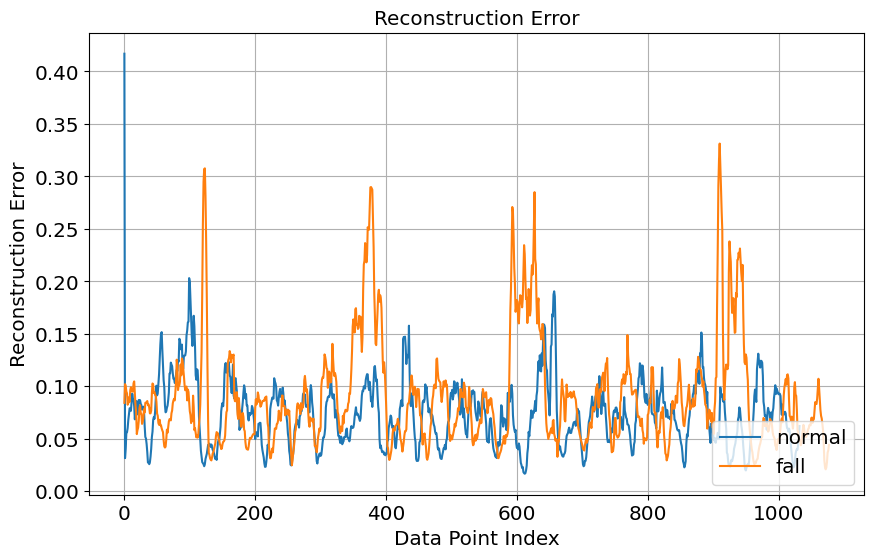

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'reconstruction_errors' is a list or array containing the reconstruction errors
# for each data point in your test set

# Plot the reconstruction errors
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_errors_per_10_frames_n, label='normal')
plt.plot(reconstruction_errors_per_10_frames, label='fall')
plt.legend(loc="lower right")
plt.title('Reconstruction Error')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))



In [ ]:

class compute_metric:
    def __init__(self):
        pass

    def detect_falls(self, loss_history, centroidZ_history, threshold):
        assert len(loss_history) == len(centroidZ_history), "ERROR: The length of loss history is different than the length of centroidZ history!"
        seq_len                 = len(loss_history)
        win_len                 = 20 # Detection window length on account of 2 seconds for 10 fps radar rate
        centroidZ_dropthres     = 0.6
        i                       = int(win_len/2)
        detected_falls_idx      = []
        # Firstly, detect the fall centers based on the centroidZ drop
        while i < (seq_len - win_len/2):
            detection_window_middle  = i
            detection_window_lf_edge = int(detection_window_middle - win_len/2)
            detection_window_rh_edge = int(detection_window_middle + win_len/2)
            # Search the centroidZ drop
            if centroidZ_history[detection_window_lf_edge] - centroidZ_history[detection_window_rh_edge] >= centroidZ_dropthres:
                detected_falls_idx.append(int(detection_window_middle))
            i += 1

        # Secondly, if a sequence of fall happen within a window less than win_len, we combine these falls into one fall centered at the middle of this sequence
        i = 0
        processed_detected_falls_idx = []
        while i < len(detected_falls_idx):
            j = i
            while True:
                if j == len(detected_falls_idx):
                    break
                if detected_falls_idx[j] - detected_falls_idx[i] > win_len:
                    break
                j += 1
            processed_detected_falls_idx.append(int((detected_falls_idx[i] + detected_falls_idx[j-1])/2))
            i = j

        # Thirdly, find id there is an anomaly level (or loss history) spike in the detection window
        ones_idx                    = np.argwhere(np.array(loss_history)>=threshold).flatten()
        fall_binseq                 = np.zeros(seq_len)
        fall_binseq[ones_idx]       = 1
        final_detected_falls_idx    = []
        i = 0
        while i < len(processed_detected_falls_idx):
            detection_window_middle  = int(processed_detected_falls_idx[i])
            detection_window_lf_edge = int(detection_window_middle - win_len/2)
            detection_window_rh_edge = int(detection_window_middle + win_len/2)
            if 1 in fall_binseq[detection_window_lf_edge:detection_window_rh_edge]:
                final_detected_falls_idx.append(processed_detected_falls_idx[i])
            i += 1

        return final_detected_falls_idx, len(processed_detected_falls_idx)

    def find_tpfpfn(self, detected_falls_idx, gt_falls_idx):
        n_detected_falls    = len(detected_falls_idx)
        falls_tp            = []
        falls_fp            = []
        falls_fn            = list(gt_falls_idx)
        win_len             = 20
        for i in range(n_detected_falls):
            n_gt_falls      = len(falls_fn)
            j               = 0
            while j < n_gt_falls:
                # Find a gt fall index whose window covers the detected fall index, so it's true positive
                if int(falls_fn[j]-win_len/2) <= detected_falls_idx[i] <= int(falls_fn[j]+win_len/2):
                    # Remove the true positive from the gt_falls_idx list, finally only false negative remains
                    falls_fn.pop(j)
                    falls_tp.append(i)
                    break
                j += 1
            # Dn not find a gt fall index whose window covers the detected fall index, so it's false positive
            if j == n_gt_falls:
                falls_fp.append(i)

        return falls_tp, falls_fp, falls_fn

    def cal_roc(self, loss_history, centroidZ_history, gt_falls_idx):
        n_gt_falls = len(gt_falls_idx)
        print("How many falls?", n_gt_falls)
        tpr, fpr = [], []
        for threshold in np.arange(0.0, 2.0, 0.02):
            detected_falls_idx, _           = self.detect_falls(loss_history, centroidZ_history, threshold)
            falls_tp, falls_fp, falls_fn    = self.find_tpfpfn(detected_falls_idx, gt_falls_idx)
            # Save the true positve rate for this threshold.
            tpr.append(len(falls_tp)/n_gt_falls)
            # Save the number of false positve, or missed fall detection, for this threshold
            fpr.append(len(falls_fp))
        return tpr, fpr

In [ ]:

    # Load the models
    model                                   = model
    all_file =  project_path + 'data/DS2/DS2'

    # Load inference dataset and the ground truth timesheet
    # Ground truth time index file exists
    if os.path.exists(all_file + '.csv'):
        gt_falls_idx                        = np.genfromtxt(all_file + '.csv', delimiter=',').astype(int)
    # Maybe this file doesn't contain any falls
    else:
        gt_falls_idx                        = []

In [ ]:

    inference_1, centroidZ_history = data_preproc().load_bin(all_file + '.npy', fortrain=False)
    #inference_1=np.array(inference_1)
    #inference = np.moveaxis(inference_1, 1, 2).reshape(inference_1.shape[0], sequence_size, embedding_dim)
    #inference = inference_1.reshape(-1, sequence_size, embedding_dim)


INFO: Total inference motion pattern data shape: (60278, 10, 64, 4)


In [ ]:
    #np.save(project_path+'inferencel.npy', inference)
    np.save(project_path+'centroidZ-h.npy', centroidZ_history)
    #inference= np.load(project_path+'inferencel.npy')

In [ ]:
    #TRANS_loss_history=model.predict(inference, batch_size=1)

    # For performace evaluation
    calculator                              = compute_metric()
    HVRAE_tpr, HVRAE_fp_total                 = calculator.cal_roc(TRANS_loss_history, centroidZ_history, gt_falls_idx)


How many falls? 50


In [ ]:
np.save(project_path+'TRANS_loss_history.npy',TRANS_loss_history)

In [ ]:
np.save(project_path+'HVRAE_tpr.npy', HVRAE_tpr)
np.save(project_path+'HVRAE_fp_total.npy', HVRAE_fp_total)

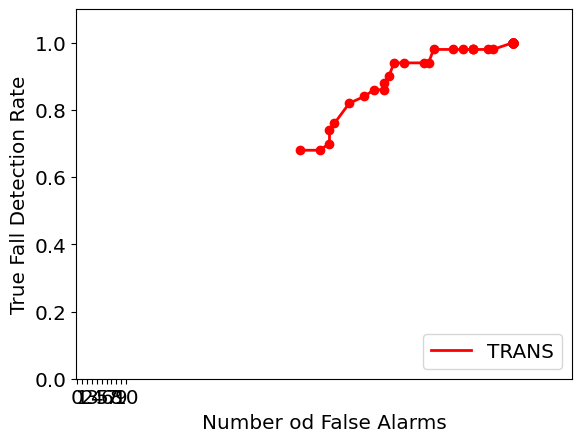

[88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 84, 83, 80, 80, 80, 78, 76, 72, 71, 70, 66, 64, 63, 62, 62, 60, 58, 55, 52, 51, 51, 49, 45]


In [ ]:
    import matplotlib.pyplot as plt
    # Plot Receiver operating characteristic (ROC) curves
    plt.figure()
    plt.xlim(-0.1, 100)
    plt.xticks(np.arange(0, 11, 1))
    plt.ylim(0.0, 1.1)
    plt.scatter(HVRAE_fp_total, HVRAE_tpr, c='r')
    plt.plot(HVRAE_fp_total, HVRAE_tpr, c='r', linewidth=2, label='TRANS')
    plt.legend(loc="lower right")
    plt.xlabel("Number od False Alarms")
    plt.ylabel("True Fall Detection Rate")
    #plt.savefig(inferencedata_file + '_ROC.png')
    plt.show()
    print(HVRAE_fp_total)
